In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
#from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
#from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression



In [2]:
train=pd.read_csv('train_final.csv')
print('Number of data_point is:-{} and Number of features/variables is:-{}'.format(train.shape[0],train.shape[1]))
print('Features :',train.columns.values)
train.head()

Number of data_point is:-3321 and Number of features/variables is:-5
Features : ['ID' 'Gene' 'Variation' 'Class' 'TEXT']


,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [3]:
test=pd.read_csv('test_final.csv')
print('Number of data_point is:-{} and Number of features/variables is:-{}'.format(test.shape[0],test.shape[1]))
print('Features :',test.columns.values)
test.head()

Number of data_point is:-5668 and Number of features/variables is:-4
Features : ['ID' 'Gene' 'Variation' 'TEXT']


,ID,Gene,Variation,TEXT
0,0,ACSL4,R570S,2 mutation resulted myeloproliferative phenoty...
1,1,NAGLU,P521L,abstract large tumor suppressor 1 lats1 serine...
2,2,PAH,L333F,vascular endothelial growth factor receptor ve...
3,3,ING1,A148D,inflammatory myofibroblastic tumor imt neoplas...
4,4,TMEM216,G77A,abstract retinoblastoma pediatric retinal tumo...


In [4]:
Y=train['Class']
X=train.drop(['ID','Class'],axis=1)
test_final=test.drop(['ID'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [5]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [6]:
print('Number of data points in train data:', X_train.shape,y_train.shape)
print('Number of data points in test data:', X_test.shape,y_test.shape)
print('Number of data points in cross validation data:', X_cv.shape,y_cv.shape)
print('Number of data points in final test datapoints:', test_final.shape)

Number of data points in train data: (2124, 3) (2124,)
Number of data points in test data: (665, 3) (665,)
Number of data points in cross validation data: (532, 3) (532,)
Number of data points in final test datapoints: (5668, 3)


## Why we use random model?

#### We use metrics as a log loss value of log loss is lies between 0 to infinity.To check what is log loss for worst model.

Log loss on Cross Validation Data using Random Model 2.4949157853911488
Log loss on Test Data using Random Model 2.497581024024258
-------------------- Confusion matrix --------------------


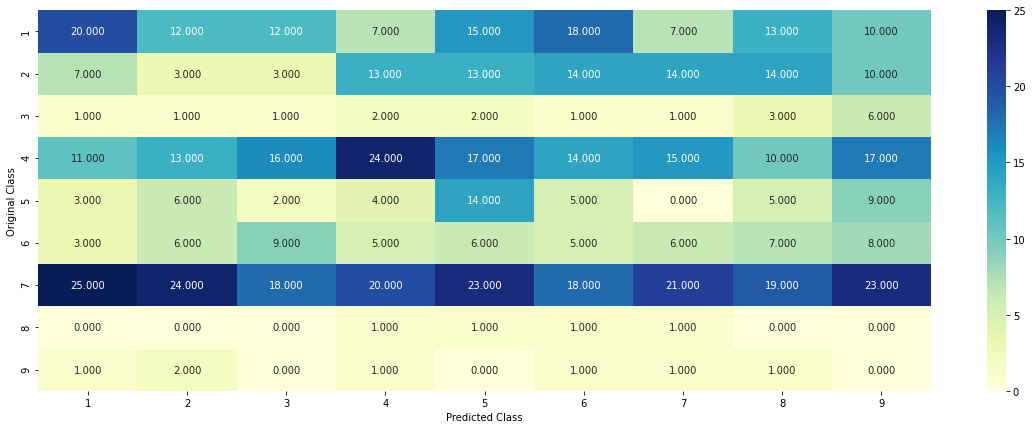

-------------------- Precision matrix (Columm Sum=1) --------------------


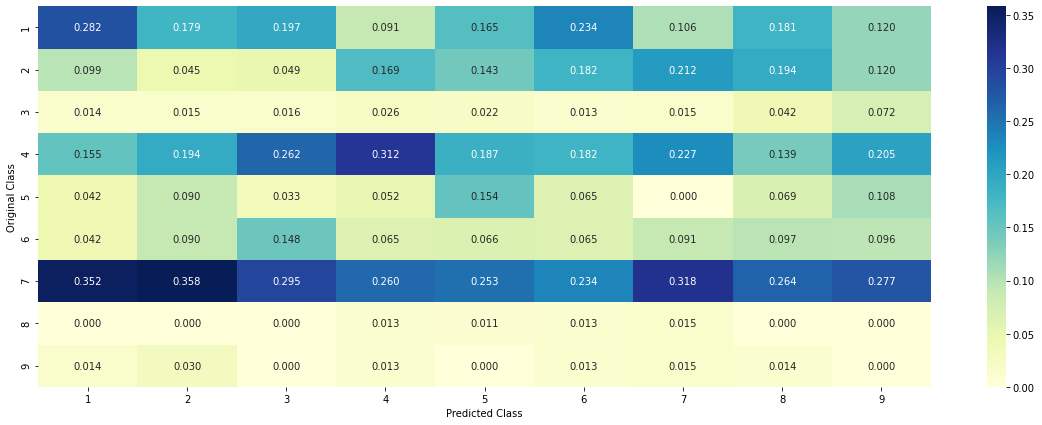

-------------------- Recall matrix (Row sum=1) --------------------


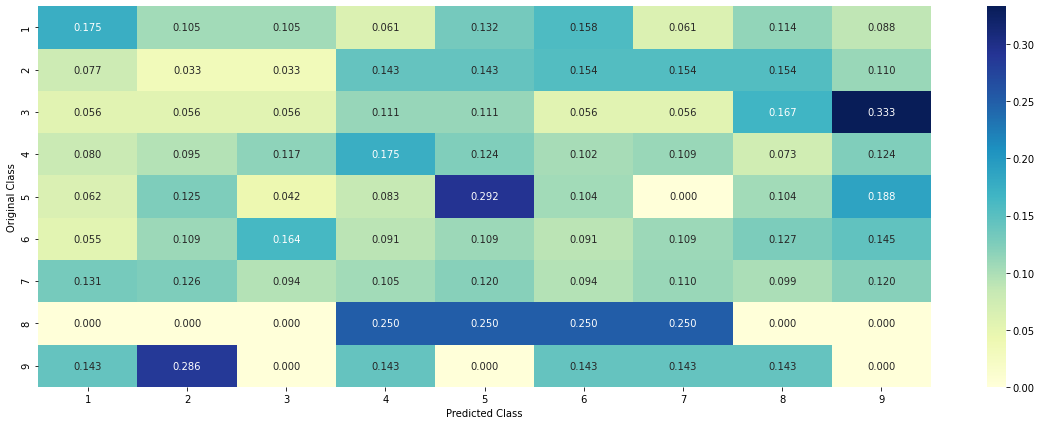

In [7]:
from sklearn.metrics import log_loss
test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [7]:
from sklearn.preprocessing import LabelBinarizer
def label_binarizer(train,test,cv,test_final):
    lb_name = LabelBinarizer(sparse_output=True)
    lb_name.fit(train)
    train_label=lb_name.transform(train)
    test_label=lb_name.transform(test)
    cv_label=lb_name.transform(cv)
    test_final_label=lb_name.transform(test_final)
    return train_label,test_label,cv_label,test_final_label

In [8]:
%%time
train_gene,test_gene,cv_gene,test_final_gene=label_binarizer(X_train['Gene'],X_test['Gene'],X_cv['Gene'],test_final['Gene'])
print(train_gene.shape,test_gene.shape,cv_gene.shape,test_final_gene.shape)

(2124, 232) (665, 232) (532, 232) (5668, 232)
Wall time: 234 ms


In [9]:
%%time
train_variation,test_variation,cv_variation,test_final_variation=label_binarizer(X_train['Variation'],X_test['Variation'],X_cv['Variation'],test_final['Variation'])
print(train_variation.shape,test_variation.shape,cv_variation.shape,test_final_variation.shape)

(2124, 1925) (665, 1925) (532, 1925) (5668, 1925)
Wall time: 1.11 s


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def text_encoding(train,test,cv,test_final,type_val,params):
    if type_val == 'BOW':
        vectorizer = CountVectorizer(ngram_range = params[0],min_df=params[1])  
    else :
        vectorizer=TfidfVectorizer(ngram_range = params[0],min_df=params[1])
    train_transform = vectorizer.fit_transform(train)
    cv_transform=vectorizer.transform(cv)
    test_final_transform=vectorizer.transform(test_final)
    test_transform = vectorizer.transform(test)
    return train_transform,test_transform,cv_transform,test_final_transform

In [11]:
%%time
train_text,test_text,cv_text,test_final_text = text_encoding(X_train['TEXT'],X_test['TEXT'],X_cv['TEXT'],test_final['TEXT'],'TFIDF',((1,1),100))
print(train_text.shape,test_text.shape,cv_text.shape,test_final_text.shape)

(2124, 5887) (665, 5887) (532, 5887) (5668, 5887)
Wall time: 2min 3s


In [12]:
%%time
from scipy.sparse import hstack
train_s=hstack((train_gene,train_variation,train_text)).tocsr().astype('float32')
test_s=hstack((test_gene,test_variation,test_text)).tocsr().astype('float32')
cv_s=hstack((cv_gene,cv_variation,cv_text)).tocsr().astype('float32')
test_final_s=hstack((test_final_gene,test_final_variation,test_final_text)).tocsr().astype('float32')

Wall time: 2.05 s


In [13]:
print("Final Train Shape",train_s.shape,y_train.shape)
print("Final Test Shape",test_s.shape,y_test.shape)
print("Final CV Shape",cv_s.shape,y_cv.shape)
print("Test shape",test_final_s.shape)

Final Train Shape (2124, 8044) (2124,)
Final Test Shape (665, 8044) (665,)
Final CV Shape (532, 8044) (532,)
Test shape (5668, 8044)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Logistic Regression without Class Balanced.

For values of alpha =  1e-05 The log loss is: 0.9838238605417103
For values of alpha =  0.0001 The log loss is: 0.9769956154953774
For values of alpha =  0.001 The log loss is: 1.047896076713548
For values of alpha =  0.01 The log loss is: 1.2257958889471603
For values of alpha =  0.1 The log loss is: 1.3997585288930185
For values of alpha =  1 The log loss is: 1.487113221367512


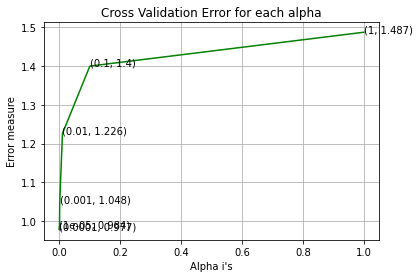

For values of best alpha =  0.0001 The train log loss is: 0.36774670852811053
For values of best alpha =  0.0001 The cross validation log loss is: 0.9769956154953774
For values of best alpha =  0.0001 The test log loss is: 0.996712382116178
Wall time: 1min 28s


In [31]:
%%time
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_s, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, y_train)
    predict_y = sig_clf.predict_proba(cv_s)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_s, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_s)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


-------------------- Confusion matrix --------------------


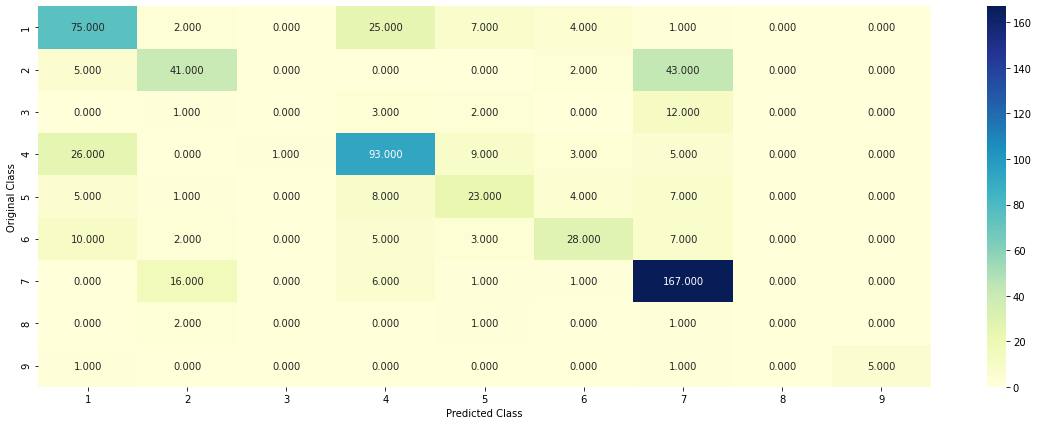

-------------------- Precision matrix (Columm Sum=1) --------------------


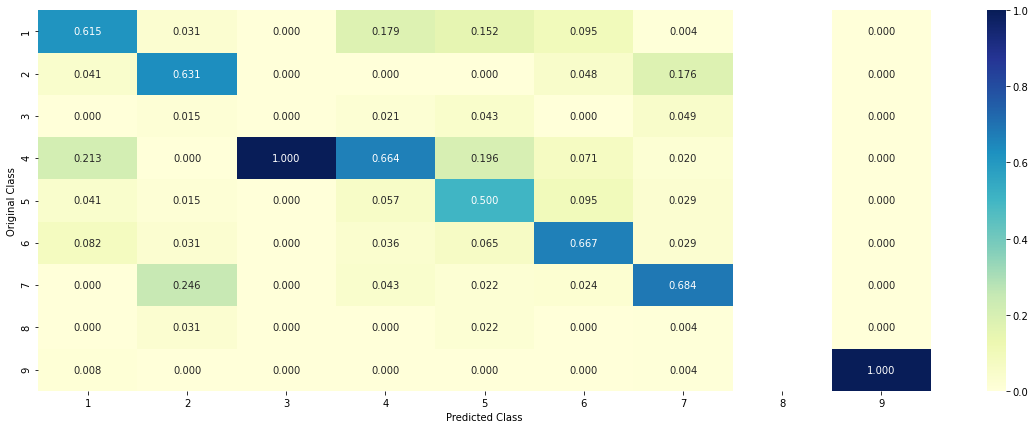

-------------------- Recall matrix (Row sum=1) --------------------


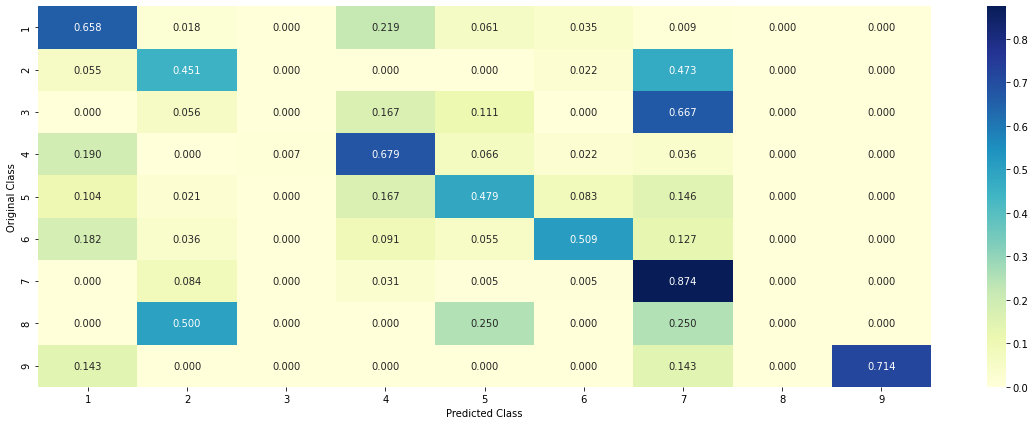

In [32]:
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# K Nearest Neighbour.

for alpha =5 Log Loss : 1.0894774859959662
for alpha =11 Log Loss : 1.118415257089295
for alpha =15 Log Loss : 1.1317369429255764
for alpha =21 Log Loss : 1.1611250772681088
for alpha =31 Log Loss : 1.181781883508299
for alpha =41 Log Loss : 1.2087297534815764
for alpha =51 Log Loss : 1.22588585638359
for alpha =99 Log Loss : 1.2512298261784103


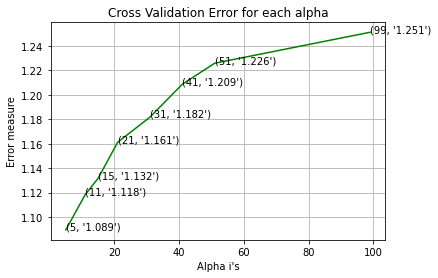

For values of best alpha =  5 The train log loss is: 0.8711532785295067
For values of best alpha =  5 The cross validation log loss is: 1.0894774859959662
For values of best alpha =  5 The test log loss is: 1.1175920281420453


In [23]:

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_s, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_s)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("for alpha ={} Log Loss : {}".format(i,log_loss(y_cv, sig_clf_probs)))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_s, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_s)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


-------------------- Confusion matrix --------------------


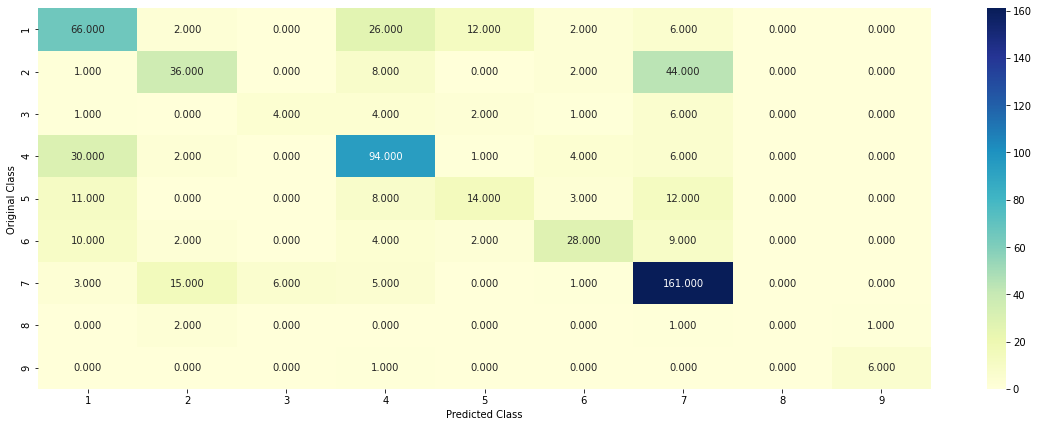

-------------------- Precision matrix (Columm Sum=1) --------------------


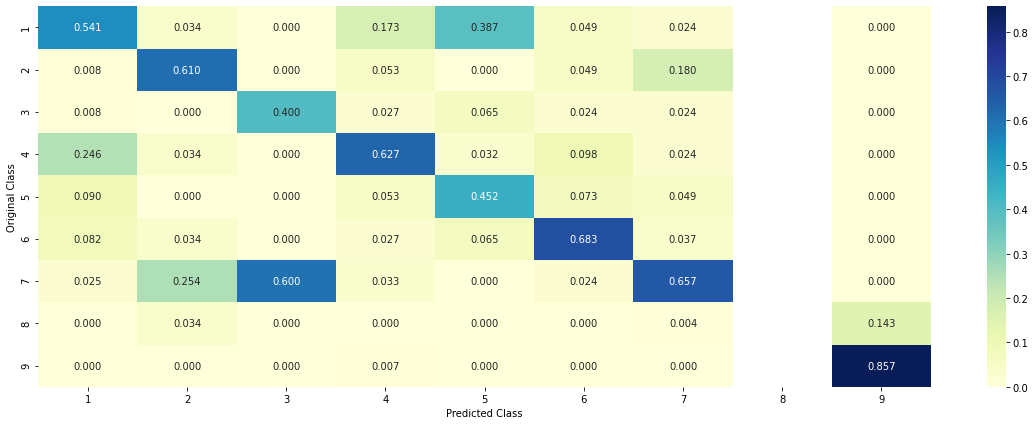

-------------------- Recall matrix (Row sum=1) --------------------


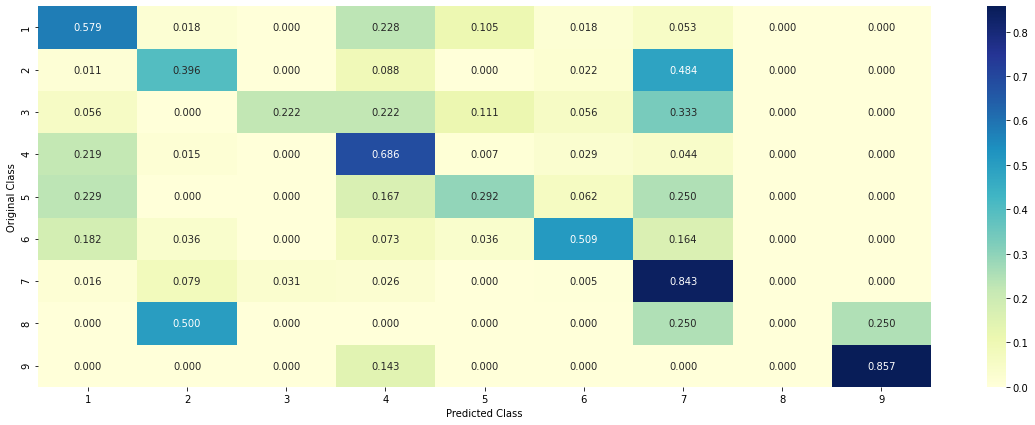

In [24]:
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# Logistic Regression with Class balanced

for alpha: 1e-06 Log Loss: 1.1270907058244795
for alpha: 1e-05 Log Loss: 1.0299738615863823
for alpha: 0.0001 Log Loss: 1.021870240264787
for alpha: 0.001 Log Loss: 1.098286712558319
for alpha: 0.01 Log Loss: 1.2716184150237677
for alpha: 0.1 Log Loss: 1.4664648854564695
for alpha: 1 Log Loss: 1.5531640499026924
for alpha: 10 Log Loss: 1.5663100226320352
for alpha: 100 Log Loss: 1.567851620188232


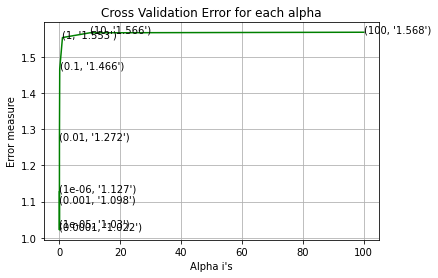

For values of best alpha =  0.0001 The train log loss is: 0.3940868000394278
For values of best alpha =  0.0001 The cross validation log loss is: 1.021870240264787
For values of best alpha =  0.0001 The test log loss is: 0.9716981174019214


In [15]:
from sklearn.metrics import log_loss
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_s, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_s)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("for alpha: {} Log Loss: {}".format(i,log_loss(y_cv, sig_clf_probs)) )

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_s, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_s)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

-------------------- Confusion matrix --------------------


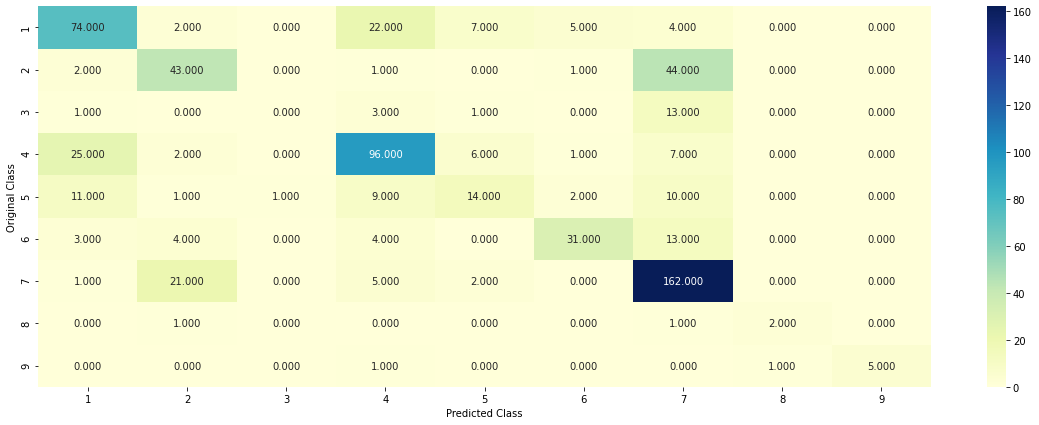

-------------------- Precision matrix (Columm Sum=1) --------------------


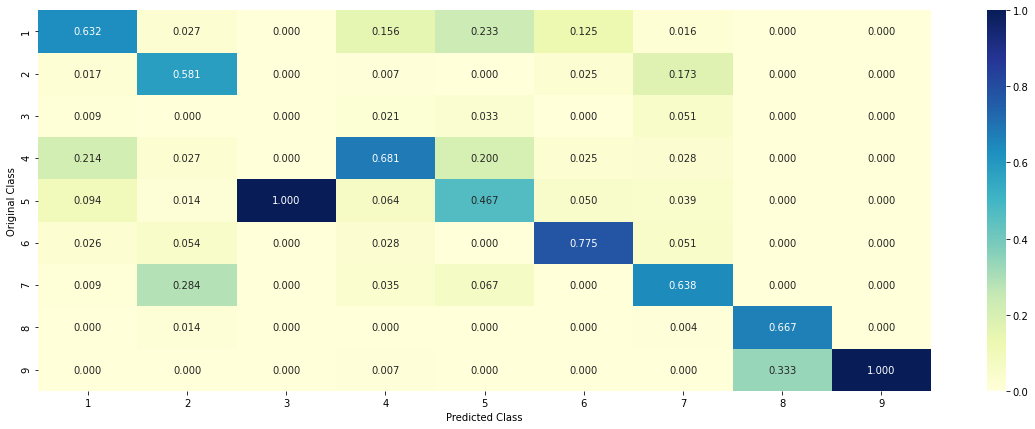

-------------------- Recall matrix (Row sum=1) --------------------


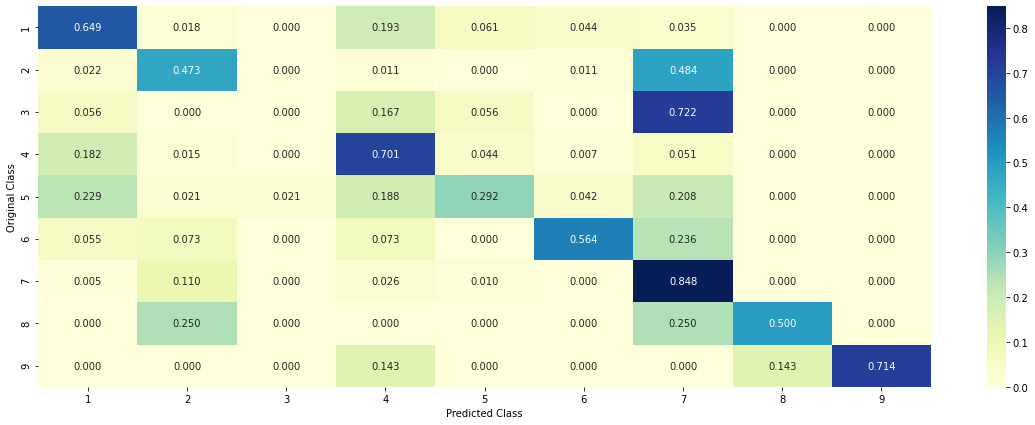

In [16]:
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

for C: 1e-05 Log Loss: 1.1064589214560978
for C: 0.0001 Log Loss: 1.0689734887885334
for C: 0.001 Log Loss: 1.1698534271635261
for C: 0.01 Log Loss: 1.360086485979124
for C: 0.1 Log Loss: 1.5221695953600842
for C: 1 Log Loss: 1.5601096225214233
for C: 10 Log Loss: 1.5601138562090546
for C: 100 Log Loss: 1.560113863177346


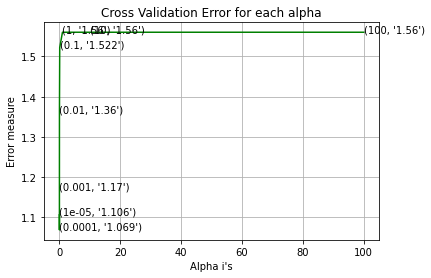

For values of best alpha =  0.0001 The train log loss is: 0.32266985218541117
For values of best alpha =  0.0001 The cross validation log loss is: 1.0689734887885334
For values of best alpha =  0.0001 The test log loss is: 1.0431578903761256


In [15]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    #clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_s, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_s)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("for C: {} Log Loss: {}".format(i,log_loss(y_cv, sig_clf_probs)))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_s,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_s)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

-------------------- Confusion matrix --------------------


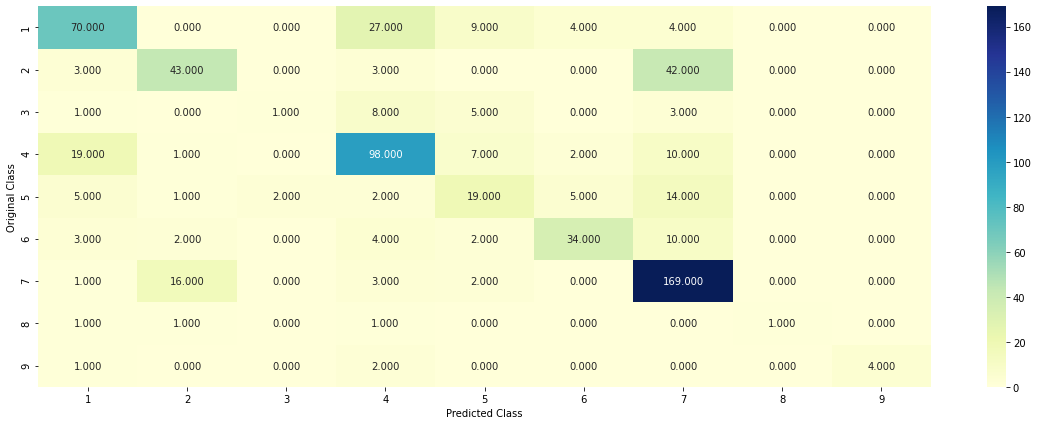

-------------------- Precision matrix (Columm Sum=1) --------------------


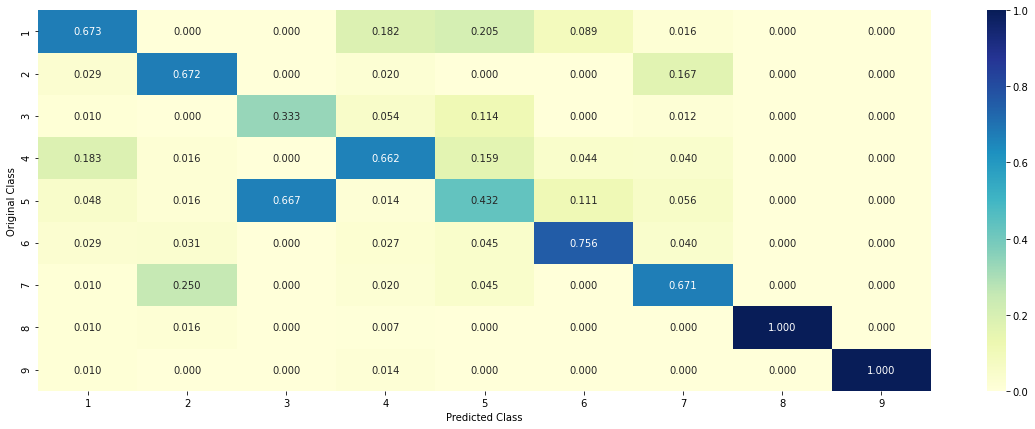

-------------------- Recall matrix (Row sum=1) --------------------


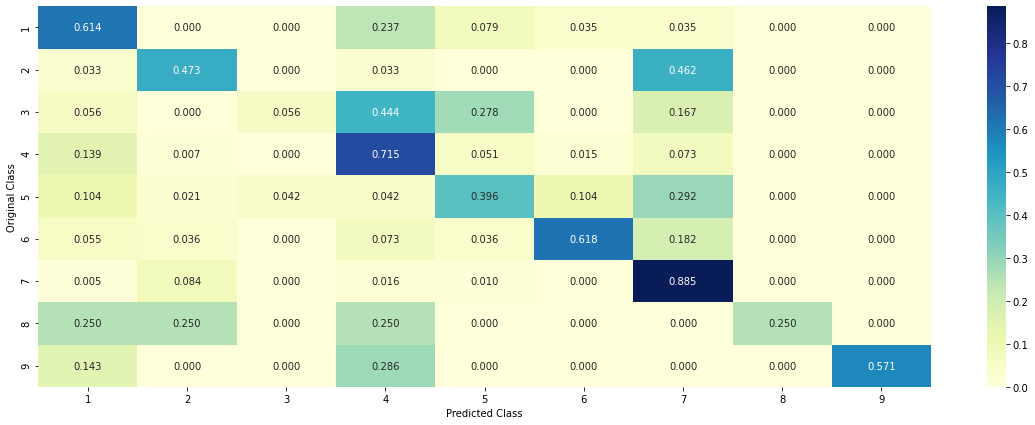

In [16]:
predicted_y =np.argmax(predict_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

In [24]:
test_y = np.array(list(y_test))

In [26]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_s,y_train)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_s[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_s[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

Predicted Class : 4
Predicted Class Probabilities: [[0.0227 0.0228 0.0099 0.8287 0.0505 0.0238 0.0344 0.0045 0.0028]]
Actual Class : 4
--------------------------------------------------


# Random ForestClassifier

In [47]:
%%time
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_s,y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_s, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_s)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("for n_estimators: {} and max depth: {} Log Loss: {}".format(i,j,log_loss(y_cv, sig_clf_probs)))



for n_estimators: 10 and max depth: 2 Log Loss: 1.4255032916024704
for n_estimators: 10 and max depth: 3 Log Loss: 1.3465148452854323
for n_estimators: 10 and max depth: 5 Log Loss: 1.2573640047271926
for n_estimators: 10 and max depth: 10 Log Loss: 1.1679314099508136
for n_estimators: 50 and max depth: 2 Log Loss: 1.3414603095175683
for n_estimators: 50 and max depth: 3 Log Loss: 1.277972460848956
for n_estimators: 50 and max depth: 5 Log Loss: 1.1708066544400875
for n_estimators: 50 and max depth: 10 Log Loss: 1.1068104161642722
for n_estimators: 100 and max depth: 2 Log Loss: 1.3437703683765754
for n_estimators: 100 and max depth: 3 Log Loss: 1.2797902066090214
for n_estimators: 100 and max depth: 5 Log Loss: 1.1563374356992622
for n_estimators: 100 and max depth: 10 Log Loss: 1.103218682227133
for n_estimators: 200 and max depth: 2 Log Loss: 1.3352663674926213
for n_estimators: 200 and max depth: 3 Log Loss: 1.261599405277313
for n_estimators: 200 and max depth: 5 Log Loss: 1.14768

In [31]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_s, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_s)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  1000 The train log loss is: 0.5479580048976479
For values of best alpha =  1000 The cross validation log loss is: 1.0950293742372958
For values of best alpha =  1000 The test log loss is: 1.0602302573927


In [36]:
#test
y_test_predicted = sig_clf.predict_proba(test_final_s)

In [37]:
print(y_test_predicted)

[[0.05283706 0.26870143 0.01685571 ... 0.53488908 0.0061754  0.00475412]
 [0.1718155  0.14630326 0.0242292  ... 0.25303724 0.00981076 0.00953547]
 [0.05671569 0.15499985 0.01725957 ... 0.61497676 0.00644015 0.00587412]
 ...
 [0.06379265 0.51518336 0.01591358 ... 0.26262792 0.0057423  0.00501035]
 [0.19068468 0.18335727 0.0227237  ... 0.32865393 0.0087477  0.00933552]
 [0.30631334 0.08468734 0.02186177 ... 0.08503509 0.00906097 0.00883459]]


In [41]:
submission_df = pd.DataFrame(y_test_predicted, columns=['class' + str(c + 1) for c in range(9)])
submission_df.insert(0,'ID',test['ID'].values,True)

In [42]:
submission_df.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,0,0.053,0.269,0.017,0.040,0.042,0.034,0.535,0.006,0.005
1,1,0.172,0.146,0.024,0.271,0.062,0.052,0.253,0.010,0.010
2,2,0.057,0.155,0.017,0.063,0.044,0.038,0.615,0.006,0.006
3,3,0.075,0.238,0.018,0.066,0.046,0.039,0.506,0.007,0.006
4,4,0.173,0.116,0.020,0.254,0.058,0.048,0.311,0.010,0.009


In [44]:
submission_df["ID"] = pd.to_numeric(submission_df["ID"], errors='coerce')

In [45]:
submission_df.to_csv('submission1.csv',index=False)

In [46]:
submission_df.shape

(5668, 10)